In [1]:
import math
import numpy as np
import torch
from torch import nn
from d2l import torch as d2l

根据此三阶多项式生成数据集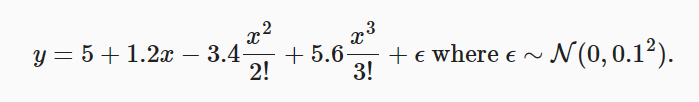

In [51]:
max_degree = 20  # 多项式的最大阶数（特征向量20维）
n_train, n_test = 100, 100  # 训练和测试数据集大小
true_w = np.zeros(max_degree) 
true_w[0:4] = np.array([5, 1.2, -3.4, 5.6]) # 初始化真实的权重值，其余16项均为0

features = np.random.normal(size=(n_train + n_test, 1)) # 200 * 1 多项式回归只需要利用一个特征x，其余维度的值均是x的幂
np.random.shuffle(features)
poly_features = np.power(features, np.arange(max_degree).reshape(1, -1)) # 特征矩阵 poly_features.shape = (200, 20)
for i in range(max_degree):
    poly_features[:, i] /= math.gamma(i + 1) # gamma(n)=(n-1)!

labels = np.dot(poly_features, true_w) # 计算这些输入的真实值
labels += np.random.normal(scale=0.1, size=labels.shape) # 加上一些噪音

In [52]:
# NumPy ndarray转换为tensor
true_w, features, poly_features, labels = [torch.tensor(x, dtype=torch.float32) for x in [true_w, features, poly_features, labels]]

features[:2], poly_features[:2, :], labels[:2]

(tensor([[ 1.1314],
         [-1.3031]]),
 tensor([[ 1.0000e+00,  1.1314e+00,  6.4008e-01,  2.4141e-01,  6.8285e-02,
           1.5452e-02,  2.9139e-03,  4.7098e-04,  6.6612e-05,  8.3741e-06,
           9.4749e-07,  9.7458e-08,  9.1890e-09,  7.9976e-10,  6.4634e-11,
           4.8754e-12,  3.4476e-13,  2.2946e-14,  1.4423e-15,  8.5891e-17],
         [ 1.0000e+00, -1.3031e+00,  8.4905e-01, -3.6880e-01,  1.2015e-01,
          -3.1313e-02,  6.8008e-03, -1.2660e-03,  2.0622e-04, -2.9859e-05,
           3.8910e-06, -4.6095e-07,  5.0056e-08, -5.0176e-09,  4.6703e-10,
          -4.0573e-11,  3.3045e-12, -2.5330e-13,  1.8338e-14, -1.2577e-15]]),
 tensor([ 5.7345, -1.4681]))

In [53]:
def evaluate_loss(net, data_iter, loss):  #@save
    """评估模型在给定数据集上的损失"""
    metric = d2l.Accumulator(2)  # 损失的总和,样本数量
    for X, y in data_iter:
        out = net(X)
        y = y.reshape(out.shape)
        l = loss(out, y)
        metric.add(l.sum(), l.numel())
    return metric[0] / metric[1]

In [54]:
def train(train_features, test_features, train_labels, test_labels, num_epochs=400):
    loss = nn.MSELoss(reduction='none')
    input_shape = train_features.shape[-1] # 计算输入特征的维数
    
    # 创建神经网络，不设置偏置，因为我们已经在多项式中实现了它
    net = nn.Sequential(nn.Linear(input_shape, 1, bias=False)) # 只有一个全连接层的nn
    batch_size = min(10, train_labels.shape[0])
    # 加载数据集
    train_iter = d2l.load_array((train_features, train_labels.reshape(-1,1)),
                                batch_size)
    test_iter = d2l.load_array((test_features, test_labels.reshape(-1,1)),
                               batch_size, is_train=False)
    # 指定优化算法
    trainer = torch.optim.SGD(net.parameters(), lr=0.01)
    
    # 画图相关
    animator = d2l.Animator(xlabel='epoch', ylabel='loss', yscale='log',
                            xlim=[1, num_epochs], ylim=[1e-3, 1e2],
                            legend=['train', 'test'])
    
    # 开始训练
    for epoch in range(num_epochs):
        d2l.train_epoch_ch3(net, train_iter, loss, trainer)
        if epoch == 0 or (epoch + 1) % 20 == 0:
            animator.add(epoch + 1, (evaluate_loss(net, train_iter, loss),
                                     evaluate_loss(net, test_iter, loss)))
    # 训练完成后打印权重
    print('weight:', net[0].weight.data.numpy())

## 演示训练正常、欠拟合与过拟合的效果

weight: [[ 5.0163646  1.2039472 -3.3987398  5.615452 ]]


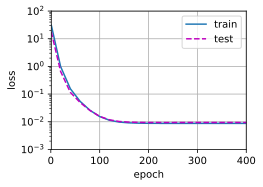

In [55]:
# 使用三阶多项式函数拟合，它与数据生成函数的阶数相同
train(poly_features[:n_train, :4], poly_features[n_train:, :4], 
      labels[:n_train], labels[n_train:])

weight: [[ 1.5014564 14.985272 ]]


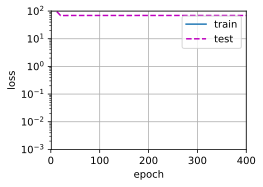

In [48]:
# 使用线性函数拟合，减少该模型的训练损失相对困难, 欠拟合了（数据没给全）
train(poly_features[:n_train, :2], poly_features[n_train:, :2], 
      labels[:n_train], labels[n_train:])

weight: [[nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
  nan nan]]


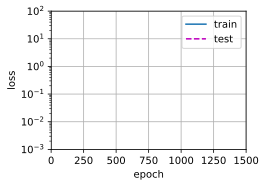

In [49]:
# 从多项式特征中选取所有维度
train(poly_features[:n_train, :], poly_features[n_train:, :],
      labels[:n_train], labels[n_train:], num_epochs=1500)